In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from scipy.fft import fft, ifft, fftfreq, fftshift
%matplotlib notebook

# Wilson algorithm 
This algorithm is translated from the pseudo-code from the appendix of <a href='https://www.scielo.br/j/rbef/a/m4LwwHLvk7YwPNMhngNJQwp/?lang=en'>this paper</a>.

In [3]:
#wilson algorithm plus operator. The operator will be used for later part. 
#plus operator
def plus(g):
    m = g.shape[0]
    nw = g.shape[2]
    beta = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            beta[i,j,:] = ifft(g[i,j,:])
    betap = beta.copy()
    beta0 = 0.5*beta[:,:,0]
    betap[:,:,0] = np.triu(beta0) 
    betap[:,:,int(nw/2):] = 0 
    gp = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            gp[i,j,:] = fft(betap[i,j,:]) 
    return gp 

In [4]:
#wilson algorithm
def wilson(s, freq, ite, tol): 
    m = s.shape[0] 
    nw = s.shape[2] 
    R = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            R[i,j,:] = ifft(s[i,j,:])
    psi = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        psi[:,:,i] = np.linalg.cholesky(R[:,:,0])
    g = np.zeros((m,m,nw))*(1+1j)
    I = np.eye(m,m)
    for t in range(0, ite, 1):
        for i in range(0, nw, 1):
            g[:,:,i] = np.linalg.inv(psi[:,:,i]) @ s[:,:,i] @ np.conj(np.linalg.inv(psi[:,:,i]).T)
            g[:,:,i] = g[:,:,i] + I 
        gp = plus(g)
        psi_old = psi.copy()
        psi_err = 0 
        for i in range(0, nw, 1):
            psi[:,:,i] = psi[:,:,i] @ gp[:,:,i]
            psi_err = psi_err + np.linalg.norm(psi[:,:,i] - psi_old[:,:,i])/nw
        if psi_err < tol: 
            break 
    A = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            A[i,j,:] = ifft(psi[i,j,:])
    A0 = A[:,:,0]
    cov = A0 @ A0.T
    H = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        H[:,:,i] = psi[:,:,i] @ np.linalg.inv(A0)
    freq_new = freq[int(len(freq)/2):] #included so that the frequency information is retained. 
    return H, cov, freq

# Simulating the equation 
The signals are simulated from the equations: 

$X_{1}(t) = 0.55 X_{1}(t-1) - 0.8 X_{1}(t-2) + C X_{2}(t-1) + \epsilon_{1}(t)$

$X_{2}(t) = 0.55 X_{2}(t-1) - 0.8 X_{2}(t-2) + \epsilon_{2}(t)$

Such that, $C = 0.25$

In [5]:
#simulation of the signals
time = 25 #time of the simulation 
fs = 200 #sampling frequency
tdata = np.arange(0, time, 1/fs) #data of the time 
tdatapoint = len(tdata)
sim = 5000 #simulation number
c=0.25

#noise for the signal
nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],[0.0, 1.0]])
x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

#signal simulation
x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))
for t in range(0, tdatapoint, 1):
    x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c*x2[:, t-1] + x1noise[:,t]
    x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + x2noise[:,t]

<IPython.core.display.Javascript object>


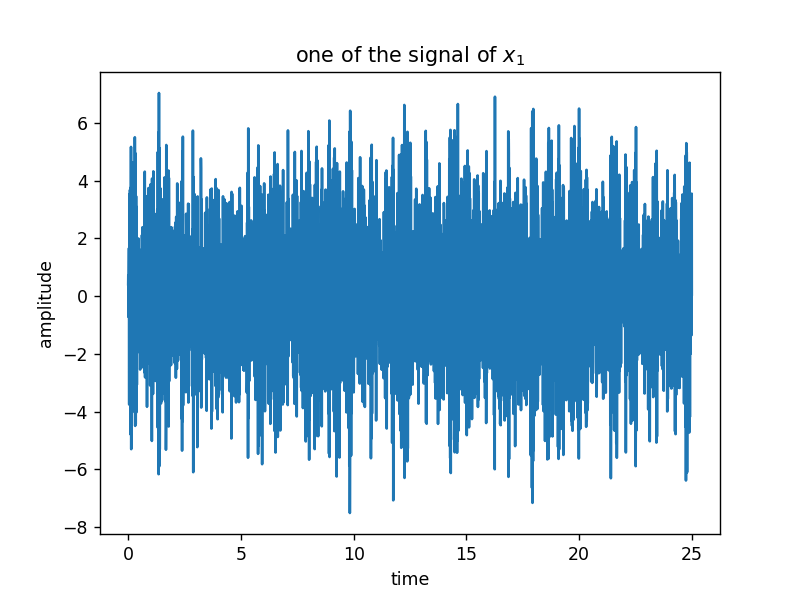

In [6]:
plt.figure()
plt.plot(tdata, x1[0])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('one of the signal of $x_{1}$')
plt.show()

<IPython.core.display.Javascript object>


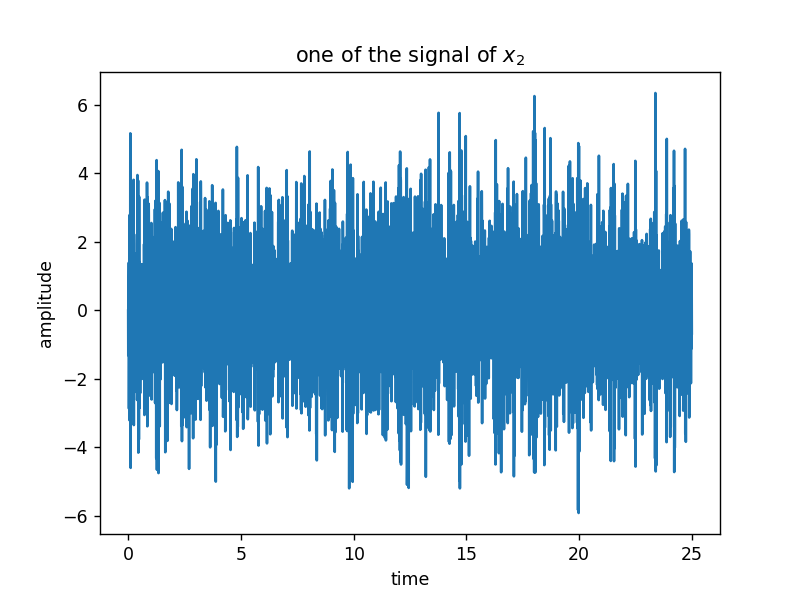

In [7]:
plt.figure()
plt.plot(tdata, x2[0])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('one of the signal of $x_{2}$')
plt.show()

In [8]:
#calculate the autospectrum of s_{11}
fx1 = fft(x1) 
freq_fx1 = fftfreq(x1[0].size, d=1/fs)
fx1_con = np.conj(fx1) 

ans11 = np.mean(fx1*fx1_con, axis=0)/(sim) #autospectrum of s_{11}

In [9]:
#calculate the autospectrum of s_{22}
fx2 = fft(x2)
freq_fx2 = fftfreq(x2[0].size, d=1/fs)
fx2_con = np.conj(fx2)

ans22 = np.mean(fx2*fx2_con, axis=0)/(sim) #autospectrum of s_{22}

In [10]:
#calculate the cross-spectrum of s_{12} and s_{21}
ans12 = np.mean(fx1*fx2_con, axis=0)/(sim) #cross-spectrum of s_{12}
ans21 = np.mean(fx2*fx1_con, axis=0)/(sim) #cross-spectrum of s_{21}

#spectral matrix at every frequency 
s = np.array([[ans11, ans12],
              [ans21, ans22]])

In [11]:
#calculate the transfer function (H) and covariance matrix (covMat) 
H, covMat, freq = wilson(s, freq_fx1, 40, 1e-20) #1st parameter = spectral matrix; 2nd parameter = frequency; 3nd parameter = # iteration; 4th parameter = error of tolerance

In [12]:
print('Comparison with covariance of the noise between [calculated] and [preset]')
print('-'*50)
print(np.round(np.real(covMat), 6), '\t Calculated (6 decimals)') 
print('-'*50)
print(ncov, '\t \t \t preset') #should be almost the same as the covariance of the noise. 

#recalculate the spectral matrix / auto-&cross-spectrum after obtaining the [transfer function] and [covariance matrix]
spect = np.zeros((H.shape[0], H.shape[1], H.shape[2]))*(1+1j)
for t in range(H.shape[2]):
    temp = H[:,:,t] @ covMat @ np.conj(H[:,:,t].T)
    spect[:,:,t] = temp

Comparison with covariance of the noise between [calculated] and [preset]
--------------------------------------------------
[[1.001843e+00 1.460000e-04]
 [1.460000e-04 1.000411e+00]] 	 Calculated (6 decimals)
--------------------------------------------------
[[1. 0.]
 [0. 1.]] 	 	 	 preset


<IPython.core.display.Javascript object>


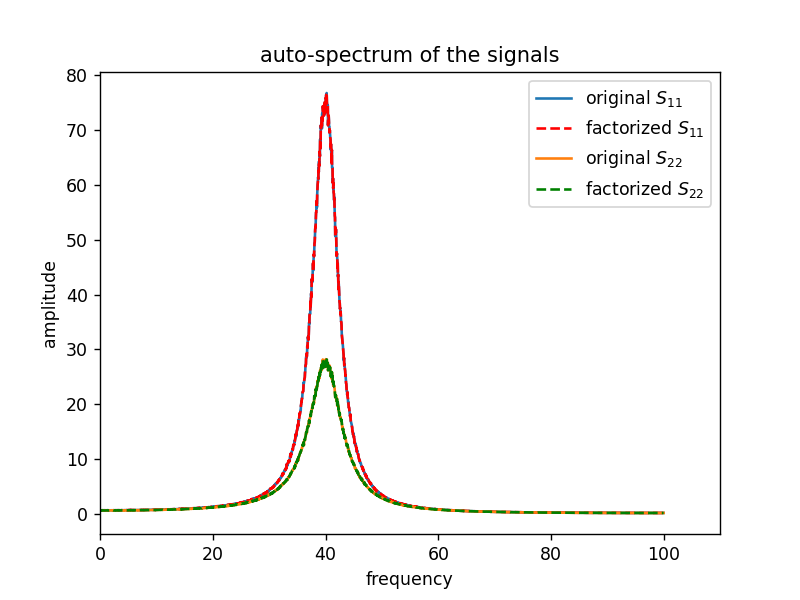

In [13]:
plt.figure()
plt.plot(fftshift(freq_fx1), fftshift(np.real(ans11)), label='original $S_{11}$')
plt.plot(fftshift(freq), fftshift(np.real(spect[0,0,:])), 'r--', label='factorized $S_{11}$')
plt.plot(fftshift(freq_fx2), fftshift(np.real(ans22)), label='original $S_{22}$')
plt.plot(fftshift(freq), fftshift(np.real(spect[1,1,:])), 'g--', label='factorized $S_{22}$')
plt.legend(loc='best')
plt.xlim(0)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('auto-spectrum of the signals')
plt.show()

In [15]:
#nonparametric granger causality
I21 = np.zeros(H.shape[2])*(1+1j) #signal 2 to signal 1
for i in range(H.shape[2]):
    Hbar11 = H[0,0,i] + covMat[0,1]*H[0,1,i]*covMat[0,0]
    temp = np.log((spect[0,0,i])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
    I21[i] = temp
    
I12 = np.zeros(H.shape[2])*(1+1j) #signal 1 to signal 2
for i in range(H.shape[2]):
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log((spect[1,1,i])/(Hhat22 * covMat[1,1] * np.conj(Hhat22)))
    I12[i] = temp
    
I12inst = np.zeros(H.shape[2])*(1+1j) #instantaneous of signal 1 and signal 2
for i in range(H.shape[2]):
    Hbar11 = H[0,0,i] + covMat[0,1]*H[0,1,i]*covMat[0,0]
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log(((Hbar11*covMat[0,0]*np.conj(Hbar11))*(Hhat22*covMat[1,1]*np.conj(Hhat22)))/(np.linalg.det(spect[:,:,i])))
    I12inst[i] = temp
    
Ispect = I21 + I12 + I12inst
cor = 1-np.exp(-Ispect)

<IPython.core.display.Javascript object>


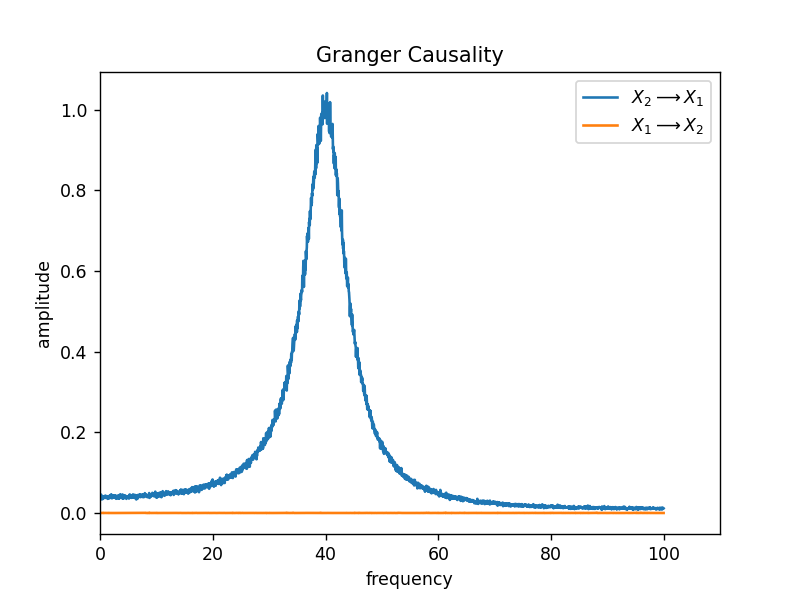

In [16]:
#non-parametric plot
plt.figure()
plt.plot(fftshift(freq), fftshift(np.real(I21)), label='$X_2 \longrightarrow X_1$')
plt.plot(fftshift(freq), fftshift(np.real(I12)), label='$X_1 \longrightarrow X_2$')
#plt.plot(fftshift(freq), fftshift(np.real(I12inst)), label='$X_1 \longleftrightarrow X_2$')
plt.legend(loc='best')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('Granger Causality')
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


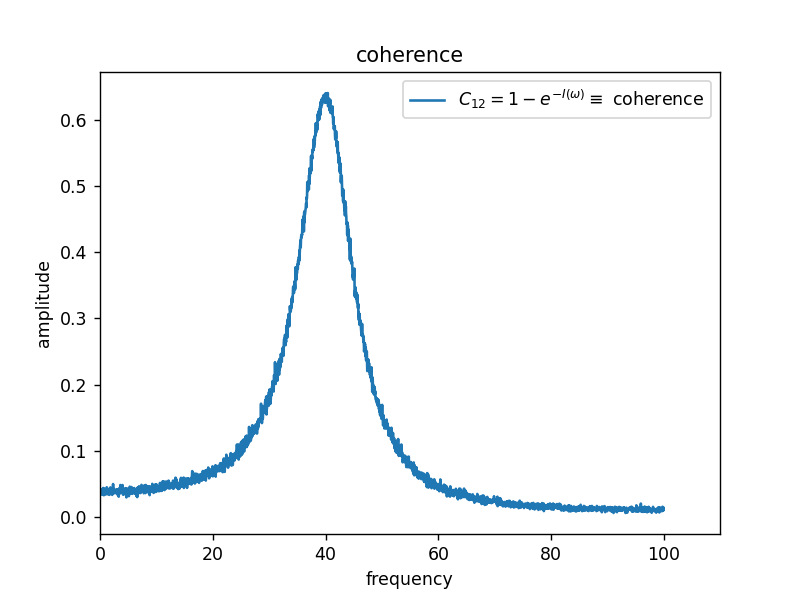

In [17]:
#non-parametric plot
plt.figure()
plt.plot(fftshift(freq), fftshift(np.real(cor)), label='$C_{12} = 1 - e^{-I(\omega)} \equiv$ coherence')
plt.legend(loc='best')
plt.xlim(0)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('coherence')
plt.show()

In [24]:
#parametric method
noise = np.array([[1.0, 0.0],[0.0, 1.0]])
const = (-1j)*(2*np.pi)
fre = fftshift(fftfreq(len(tdata), d=tdata[1]-tdata[0]))
fre_new = (fre)/(np.max(fre))
spec = np.zeros([2, 2, len(fre)])*(1+1j)

#transfer matrix's elements
a = 1 - 0.55*np.exp(const*1*fre_new) + 0.8*np.exp(const*2*fre_new)
b = -0.25*np.exp(const*1*fre_new)
c = 0*np.exp(const*1*fre_new)
d = 1 - 0.55*np.exp(const*1*fre_new) + 0.8*np.exp(const*2*fre_new)

matA = np.array([[a, b],[c, d]]) #transfer matrix

#spectrum calculation
for i in range(matA.shape[2]):
    H = np.linalg.inv(matA[:,:,i])
    spec[:,:,i] = H @ noise @ np.conj(np.matrix.transpose(H))

<IPython.core.display.Javascript object>


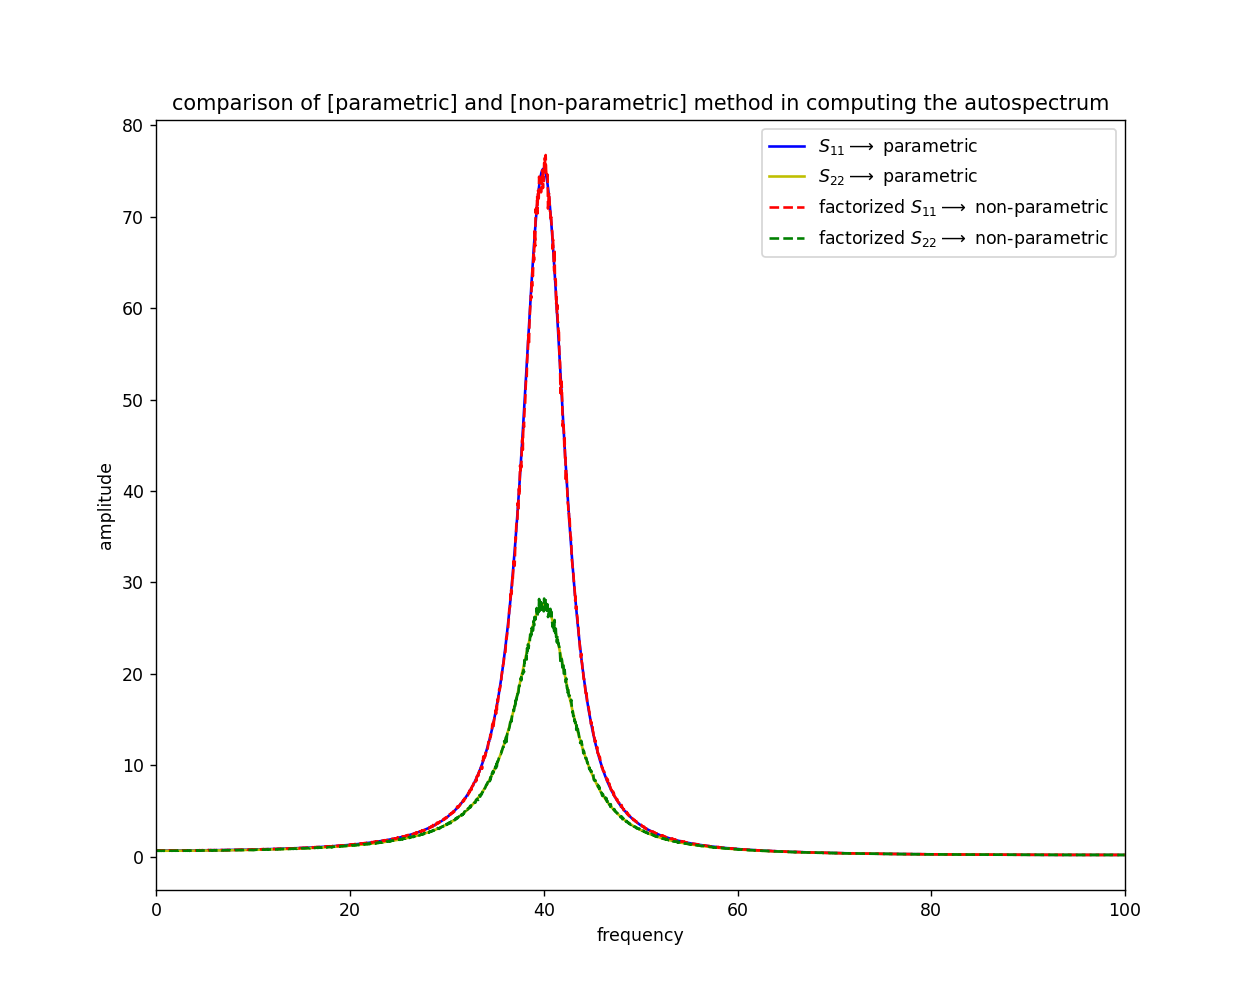

In [27]:
plt.figure(figsize = (10, 8))
plt.plot(fre_new*2*np.max(fre), np.real(spec[0,0,:]), 'b-', label='$S_{11} \longrightarrow$ parametric')
plt.plot(fre_new*2*np.max(fre), np.real(spec[1,1,:]), 'y-', label='$S_{22} \longrightarrow$ parametric')
plt.plot(fftshift(freq), fftshift(np.real(spect[0,0,:])), 'r--', label='factorized $S_{11} \longrightarrow$ non-parametric')
plt.plot(fftshift(freq), fftshift(np.real(spect[1,1,:])), 'g--', label='factorized $S_{22} \longrightarrow$ non-parametric')
plt.legend(loc='best')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('comparison of [parametric] and [non-parametric] method in computing the autospectrum')
plt.xlim(0, 100)
plt.show()